# Lib

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math

In [ ]:
! pip -q install torchtext==0.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.3 MB/s eta 0:00:00


# Hyperparameter

In [ ]:
opt = {
    'SRC_LANGUAGE':"en",
    'TGT_LANGUAGE':"vi",
    'N':2,
    'd_model':512,
    'd_ff':2048,
    'h':8,
    'dk':32,
    'dv':16,
    'dropout': 0.1,
    'lr':0.0001,
    'epochs':10,
    'MAX_SEQ_LEN':128,
    'BATCH_SIZE':64,
    'device':"cuda" if torch.cuda.is_available() else "cpu",
}

# Transformer Model

## Embedding Layer with Position Encoding

In [ ]:
class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.embed = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embed(x)

In [ ]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_length=opt['MAX_SEQ_LEN'], dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)

        # Tính positional encoding với vector hóa thay vì vòng lặp
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_seq_length, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # Thêm batch dimension
        self.register_buffer('pe', pe)  # Đảm bảo không tính gradient

    def forward(self, x):
        x = x * math.sqrt(self.d_model)
        pe = self.pe[:, :x.size(1)].to(x.device)
        x = x + pe
        return self.dropout(x)

# PositionalEncoder(512)(torch.rand(5, 30, 512)).shape

## Encoder and Self Attention Layer


In [ ]:
def attention(q, k, v, mask=None, dropout=None):
    """
    q: batch_size x head x seq_length x d_model
    k: batch_size x head x seq_length x d_model
    v: batch_size x head x seq_length x d_model
    mask: batch_size x 1 x 1 x seq_length
    output: batch_size x head x seq_length x d_model
    """

    # attention score được tính bằng cách nhân q với k
    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1))/math.sqrt(d_k)

    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask==0, -1e9)

    scores = F.softmax(scores, dim=-1)

    if dropout is not None:
        scores = dropout(scores)

    output = torch.matmul(scores, v)
    return output, scores

# attention(torch.rand(32, 8, 30, 512), torch.rand(32, 8, 30, 512), torch.rand(32, 8, 30, 512)).shape

## Multi Head Attention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()
        assert d_model % heads == 0

        self.d_model = d_model
        self.d_k = d_model//heads
        self.h = heads
        self.attn = None

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        """
        q: batch_size x seq_length x d_model
        k: batch_size x seq_length x d_model
        v: batch_size x seq_length x d_model
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """
        bs = q.size(0)
        # nhân ma trận trọng số q_linear, k_linear, v_linear với dữ liệu đầu vào q, k, v
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # tính attention score
        scores, self.attn = attention(q, k, v, mask, self.dropout)

        concat = scores.transpose(1, 2).contiguous().view(bs, -1, self.d_model)

        output = self.out(concat)
        return output

# MultiHeadAttention(8, 512)(torch.rand(32, 30, 512), torch.rand(32, 30, 512), torch.rand(32, 30, 512)).shape

## FeedForward và Normalization Layer

In [ ]:
class Norm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        self.layer_norm = nn.LayerNorm(d_model, eps=eps)

    def forward(self, x):
        return self.layer_norm(x)

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=opt['d_ff'], dropout = 0.1):
        super().__init__()

        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

## EncoderLayer

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        """
        x: batch_size x seq_length x d_model
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """

        x2 = self.norm_1(x)
        # tính attention value
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

# EncoderLayer(512, 8)(torch.rand(32, 30, 512), torch.rand(32 , 1, 30)).shape

## Decoder and Masked Multi Head Attention

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)

        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)

        self.attn_1 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.attn_2 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)

    def forward(self, x, e_outputs, src_mask, trg_mask):
        """
        x: batch_size x seq_length x d_model
        e_outputs: batch_size x seq_length x d_model
        src_mask: batch_size x 1 x seq_length
        trg_mask: batch_size x seq_length x seq_length
        """
        x2 = self.norm_1(x)
        # multihead attention
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        # masked mulithead attention thứ 2. k, v là giá trị output của mô hình encoder
        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs, src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x

# DecoderLayer(512, 8)(torch.rand(32, 30, 512), torch.rand(32, 30, 512), torch.rand(32, 1, 30), torch.rand(32, 1, 30)).shape

## Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = nn.ModuleList([EncoderLayer(d_model, heads, dropout) for _ in range(N)])
        self.norm = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)

    def forward(self, src, mask):
        """
        src: batch_size x seq_length
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """
        x = self.embed(src)
        x = self.pe(x)
        for layer in self.layers:  # Duyệt qua từng lớp trong ModuleList
            x = layer(x, mask)
        return self.norm(x)

# Encoder(232, 512,6,8,0.1)(torch.LongTensor(32, 30).random_(0, 10), torch.rand(32, 1, 30)).shape

## Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = nn.ModuleList([DecoderLayer(d_model, heads, dropout) for _ in range(N)])
        self.norm = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        """
        trg: batch_size x seq_length
        e_outputs: batch_size x seq_length x d_model
        src_mask: batch_size x 1 x seq_length
        trg_mask: batch_size x seq_length x seq_length
        output: batch_size x seq_length x d_model
        """
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

# Decoder(232, 512, 6, 8, 0.1)(torch.LongTensor(32, 30).random_(0, 10), torch.rand(32, 30, 512), torch.rand(32, 1, 30), torch.rand(32, 1, 30)).shape

## Transformer

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads, dropout):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads, dropout)
        self.decoder = Decoder(trg_vocab, d_model, N, heads, dropout)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src, trg, src_mask, trg_mask):
        """
        src: batch_size x seq_length
        trg: batch_size x seq_length
        src_mask: batch_size x 1 x seq_length
        trg_mask batch_size x seq_length x seq_length
        output: batch_size x seq_length x vocab_size
        """
        e_outputs = self.encoder(src, src_mask)

        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output

# Transformer(232, 232, 512, 6, 8, 0.1)(torch.LongTensor(32, 30).random_(0, 10), torch.LongTensor(32, 30).random_(0, 10),torch.rand(32, 1, 30),torch.rand(32, 1, 30)).shape

In [ ]:
Transformer(232, 232, 512, 6, 8, 0.1)(torch.LongTensor(32, 30).random_(0, 10), torch.LongTensor(32, 30).random_(0, 10),torch.rand(32, 1, 30),torch.rand(32, 30, 30)).shape

torch.Size([32, 30, 232])

# Load Train

In [ ]:
! gdown --id 179Evx1sNfupWC5_wPPjB0_hOebg_Z-wL

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=179Evx1sNfupWC5_wPPjB0_hOebg_Z-wL
From (redirected): https://drive.google.com/uc?id=179Evx1sNfupWC5_wPPjB0_hOebg_Z-wL&confirm=t&uuid=1df91d00-20be-4cc5-b5b4-5926b57c3a75
To: /content/machine-translation/bilstm3 (1).pth
100% 273M/273M [00:06<00:00, 42.5MB/s]


In [ ]:
! gdown --id 1pRfhDdF5Oc2zI5BMUyy5AsYcPlpwkY1n

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1pRfhDdF5Oc2zI5BMUyy5AsYcPlpwkY1n
From (redirected): https://drive.google.com/uc?id=1pRfhDdF5Oc2zI5BMUyy5AsYcPlpwkY1n&confirm=t&uuid=300a7351-a7fa-4be6-a6cc-44e084f54028
To: /content/transformer.pth
100% 150M/150M [00:03<00:00, 37.5MB/s]


In [ ]:
class TransformerScratch(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads, dropout):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads, dropout)
        self.decoder = Decoder(trg_vocab, d_model, N, heads, dropout)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src, trg, src_mask, trg_mask):
        """
        src: batch_size x seq_length
        trg: batch_size x seq_length
        src_mask: batch_size x 1 x seq_length
        trg_mask batch_size x seq_length x seq_length
        output: batch_size x seq_length x vocab_size
        """
        e_outputs = self.encoder(src, src_mask)

        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output

In [ ]:
model = TransformerScratch(
    src_vocab=34687,
    trg_vocab=21681,
    d_model=256,
    N=6,
    heads=8,
    dropout=0.1
)

In [ ]:
model.load_state_dict(torch.load('./transformer.pth'))

<ipython-input-21-0d454620de66>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./transformer.pth'))


<All keys matched successfully>

In [ ]:
model = torch.load('/content/machine-translation/bilstm3.pth', map_location=torch.device('cpu'))

<ipython-input-53-f4a2aed5d249>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/machine-translation/bilstm3.pth', map_location=torch.device('cp

In [ ]:
model(torch.rand(32, 30), torch.rand(32, 30))

TypeError: 'collections.OrderedDict' object is not callable

In [ ]:
vi_tokenizer = ViTokenizer()
en_tokenizer = EnTokenizer()
en_vocab = Vocabulary.load('./ckpts/en_vocab.json')
vi_vocab = Vocabulary.load('./ckpts/vi_vocab.json')

In [ ]:
sentence='My family is very poor, I had to go through hard life when I was young, now I have a better life.'.lower()
tokenized_sentence = en_tokenizer.tokenize(sentence)
print(tokenized_sentence)
index = en_vocab.words2indexes(tokenized_sentence)
print(index)
decoder = en_vocab.indexes2words(index)
print(decoder)

['my', 'family', 'is', 'very', 'poor', ',', 'i', 'had', 'to', 'go', 'through', 'hard', 'life', 'when', 'i', 'was', 'young', ',', 'now', 'i', 'have', 'a', 'better', 'life', '.']
[52, 223, 16, 134, 1079, 5, 13, 92, 7, 100, 162, 369, 149, 62, 13, 27, 439, 5, 86, 13, 33, 11, 205, 149, 4]
['my', 'family', 'is', 'very', 'poor', ',', 'i', 'had', 'to', 'go', 'through', 'hard', 'life', 'when', 'i', 'was', 'young', ',', 'now', 'i', 'have', 'a', 'better', 'life', '.']


# Data setup

## Lib

In [ ]:
!pip install -q datasets lightning

In [ ]:
from datasets import DatasetDict
import lightning as pl
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from tqdm import tqdm

## Load data

In [ ]:
!gdown --folder 1cPdLNnTlsj3N1FE9x6_K608bCAaYaVGM -O data

Retrieving folder contents
Retrieving folder 1OEYSMb7DHvhpHDkyErFfepIjeyDOiDR4 dev
Processing file 1Koyp92dplbh_S_9UW8wvskbzHW6Gb5Zw dev.en
Processing file 1KVzIWM8IUIS_NdWpctOd_l3FIm901e6L dev.vi
Retrieving folder 1FkG-m-LSXaXCrau3yD8s9_f8Llda3KoF test
Processing file 18XurJYc9T8i4JKzGRknNIMzEBD5bLDex test.en
Processing file 1atCidgee403dxm8mAWIXq9mlfdcYSXc_ test.vi
Retrieving folder 1jrfK8TmZghXISDq7JI-LTZyItZRgnEn2 train
Processing file 1jR128Bdo7vyQc1OPBCE6zEz0gXF6eUDY train.en
Processing file 1hKt2ww1-zZHzXRPl_0ijxUxdWK57XKp1 train.vi
Processing file 13k-89zbeCEaZ3qc4VMzWexLsJ-BK7XaT dev.pkl
Processing file 1VQpPiTI6lKTCVVx2PcYmQ28hqgXg3Pc0 test.pkl
Processing file 18PGE3eFJ1Xl9Ffba1KTL1kKfe-yO3VFj train.pkl
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1Koyp92dplbh_S_9UW8wvskbzHW6Gb5Zw
To: /content/data/dev/dev.en
100% 1.42M/1.42M [00:00<00:00, 118MB/s]
Downloading...
Fr

In [ ]:
def read_data(src_file, trg_file):
    src_data = open(src_file).read().strip().split('\n')
    trg_data = open(trg_file).read().strip().split('\n')

    return src_data, trg_data

In [ ]:
src_train, tgt_train = read_data("/content/data/train/train.en", "/content/data/train/train.vi")
src_val, tgt_val = read_data("/content/data/dev/dev.en", "/content/data/dev/dev.vi")
src_test, tgt_test = read_data("/content/data/test/test.en", "/content/data/test/test.vi")

In [ ]:
def save_data(src_data, trg_data, src_output_file, trg_output_file, num_lines=500000):
    # Cắt chỉ lấy num_lines đầu tiên
    src_subset = src_data[:num_lines]
    trg_subset = trg_data[:num_lines]

    # Ghi dữ liệu vào file
    with open(src_output_file, 'w', encoding='utf-8') as src_out:
        src_out.write('\n'.join(src_subset) + '\n')

    with open(trg_output_file, 'w', encoding='utf-8') as trg_out:
        trg_out.write('\n'.join(trg_subset) + '\n')

In [ ]:
save_data(src_train, tgt_train, "/content/data/train/train_500k.en", "/content/data/train/train_500k.vi", num_lines=500000)

In [ ]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_dict({"en": src_train[:500000], "vi": tgt_train[:500000]})
validation_dataset = Dataset.from_dict({"en": src_val, "vi": tgt_val})
test_dataset = Dataset.from_dict({"en": src_test, "vi": tgt_test})

dataset = DatasetDict({
    "train": train_dataset,
    "validation": validation_dataset,
    "test": test_dataset
})

dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'vi'],
        num_rows: 500000
    })
    validation: Dataset({
        features: ['en', 'vi'],
        num_rows: 18719
    })
    test: Dataset({
        features: ['en', 'vi'],
        num_rows: 19151
    })
})

## Github

In [ ]:
!pip install -q underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 34.4 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
!git clone https://github.com/quangster/machine-translation

Cloning into 'machine-translation'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 151 (delta 57), reused 129 (delta 38), pack-reused 0 (from 0)
Receiving objects: 100% (151/151), 6.40 MiB | 18.82 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [ ]:
%cd machine-translation

/content/machine-translation


In [ ]:
from src.data import Vocabulary, EnTokenizer, ViTokenizer, MTDataset
from tqdm import tqdm

## Dataloader

In [ ]:
class TranslationDataModule(pl.LightningDataModule):
    def __init__(self, en_tokenizer, vi_tokenizer, en_vocab, vi_vocab, dataset, max_seq_len, batch_size):
        super().__init__()
        self.dataset_dict = dataset
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.en_tokenizer = en_tokenizer
        self.vi_tokenizer = vi_tokenizer
        self.vi_vocab = vi_vocab
        self.en_vocab = en_vocab

    def setup(self, stage=None):
        self.dataset_dict = self._preprocess_data(self.dataset_dict)
        self.train_dataset = MTDataset(
              inputs=[self.en_vocab.words2indexes(sent, add_sos_eos=True) for sent in self.dataset_dict['train']['en']],
              outputs=[self.vi_vocab.words2indexes(sent, add_sos_eos=True) for sent in self.dataset_dict['train']['vi']],
              max_length=self.max_seq_len,
              padding_idx=en_vocab['<pad>'],
          )
        self.val_dataset = MTDataset(
              inputs=[self.en_vocab.words2indexes(sent, add_sos_eos=True) for sent in self.dataset_dict['validation']['en']],
              outputs=[self.vi_vocab.words2indexes(sent, add_sos_eos=True) for sent in self.dataset_dict['validation']['vi']],
              max_length=self.max_seq_len,
              padding_idx=en_vocab['<pad>'],
          )
        self.test_dataset = MTDataset(
              inputs=[self.en_vocab.words2indexes(sent, add_sos_eos=True) for sent in self.dataset_dict['test']['en']],
              outputs=[self.vi_vocab.words2indexes(sent, add_sos_eos=True) for sent in self.dataset_dict['test']['vi']],
              max_length=self.max_seq_len,
              padding_idx=en_vocab['<pad>'],
          )

    def _preprocess_data(self, dataset_dict):
        processed_data = {
            "train": {
                "en": [self.en_tokenizer.tokenize(sent.lower()) for sent in dataset_dict['train']['en']],
                "vi": [self.vi_tokenizer.tokenize(sent.lower()) for sent in dataset_dict['train']['vi']]
            },
            "validation": {
                "en": [self.en_tokenizer.tokenize(sent.lower()) for sent in dataset_dict['validation']['en']],
                "vi": [self.vi_tokenizer.tokenize(sent.lower()) for sent in dataset_dict['validation']['vi']]
            },
            "test": {
                "en": [self.en_tokenizer.tokenize(sent.lower()) for sent in dataset_dict['test']['en']],
                "vi": [self.vi_tokenizer.tokenize(sent.lower()) for sent in dataset_dict['test']['vi']]
            }
        }

        # Create new datasets with preprocessed data
        updated_dataset_dict = DatasetDict({
            "train": Dataset.from_dict(processed_data["train"]),
            "validation": Dataset.from_dict(processed_data["validation"]),
            "test": Dataset.from_dict(processed_data["test"])
        })

        return updated_dataset_dict # Return the updated dataset


    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=2, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=2, pin_memory=True)

In [ ]:
en_vocab = Vocabulary.load('./ckpts/en_vocab.json')
vi_vocab = Vocabulary.load('./ckpts/vi_vocab.json')
vi_tokenizer = ViTokenizer()
en_tokenizer = EnTokenizer()
data_module = TranslationDataModule(en_tokenizer, vi_tokenizer, en_vocab, vi_vocab, dataset, opt['MAX_SEQ_LEN'], opt['BATCH_SIZE'])
data_module.setup()

In [ ]:
for batch in data_module.train_dataloader():
    x,y = batch
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 128])
torch.Size([64, 128])


# Config Training

## Optimizer

In [ ]:
class ScheduledOptim():
    def __init__(self, optimizer, init_lr, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.init_lr = init_lr
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients with the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))

    def state_dict(self):
        optimizer_state_dict = {
            'init_lr': self.init_lr,
            'd_model': self.d_model,
            'n_warmup_steps': self.n_warmup_steps,
            'n_steps': self.n_steps,
            '_optimizer': self._optimizer.state_dict(),
        }
        return optimizer_state_dict

    def load_state_dict(self, state_dict):
        self.init_lr = state_dict['init_lr']
        self.d_model = state_dict['d_model']
        self.n_warmup_steps = state_dict['n_warmup_steps']
        self.n_steps = state_dict['n_steps']
        self._optimizer.load_state_dict(state_dict['_optimizer'])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''
        self.n_steps += 1
        lr = self.init_lr * self._get_lr_scale()
        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

## Criterion Label Smoothing



In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, padding_idx, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim
        self.padding_idx = padding_idx

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 2))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
            true_dist[:, self.padding_idx] = 0
            mask = torch.nonzero(target.data == self.padding_idx, as_tuple=False)
            if mask.dim() > 0:
                true_dist.index_fill_(0, mask.squeeze(), 0.0)

        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

## BLEU score

In [ ]:
from torchtext.data.metrics import bleu_score
from tqdm import tqdm

def bleu(src_data, trg_data, model, vi_tokenizer, en_tokenizer, en_vocab, vi_vocab, device, k=5, max_len=128):
    total_bleu = 0.0
    num_sentences = len(src_data)

    for src_sentence, trg_sentence in tqdm(zip(src_data, trg_data), total=num_sentences):
        # Dịch câu nguồn sang câu đích
        pred_sentence = translate_sentence(src_sentence, model, en_tokenizer, en_vocab, vi_vocab, device, k, max_len)

        # Tokenize câu dịch và câu tham chiếu
        pred_tokens = vi_tokenizer.tokenize(pred_sentence)
        trg_tokens = [vi_tokenizer.tokenize(trg_sentence)]

        # Tính BLEU cho câu này
        bleu = bleu_score([pred_tokens], [trg_tokens])
        total_bleu += bleu

    # Tính điểm BLEU trung bình
    average_bleu = total_bleu / num_sentences
    return total_bleu, average_bleu

# Translation Model

In [ ]:
from transformers import get_scheduler
from torch.optim import AdamW

In [ ]:
class TranslationModel(pl.LightningModule):
    def __init__(self, n_src_vocab, n_trg_vocab, src_pad_idx, trg_pad_idx, opt):
        super().__init__()
        self.save_hyperparameters()
        self.n_src_vocab = n_src_vocab
        self.n_trg_vocab = n_trg_vocab
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.opt = opt

        self.model = Transformer(
            n_src_vocab,
            n_trg_vocab,
            opt['d_model'],
            opt['N'],
            opt['h'],
            opt['dropout']
        )
        self.criterion = LabelSmoothingLoss(
            n_trg_vocab,
            padding_idx=trg_pad_idx,
            smoothing=0.1
        )
        self._reset_parameters()

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def _create_masks(self, src, trg, src_pad, trg_pad):
        """
        Tạo mask cho encoder và decoder:
        - src_mask: Che padding token trong chuỗi nguồn.
        - trg_mask: Kết hợp mask padding và look-ahead mask trong chuỗi đích.
        """
        # Tạo src_mask: (batch_size, 1, seq_length_src)
        src_mask = (src != src_pad).unsqueeze(1)

        trg_mask = None
        if trg is not None:
            # Mask padding: (batch_size, 1, seq_length_trg)
            trg_padding_mask = (trg != trg_pad).unsqueeze(1)

            # Mask look-ahead: (seq_length_trg, seq_length_trg)
            trg_seq_len = trg.size(1)
            look_ahead_mask = torch.triu(torch.ones((trg_seq_len, trg_seq_len), device=self.opt['device']), diagonal=1).bool()

            # Kết hợp padding mask và look-ahead mask: (batch_size, seq_length_trg, seq_length_trg)
            trg_mask = trg_padding_mask & ~look_ahead_mask.unsqueeze(0)

        return src_mask, trg_mask

    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.model(src, tgt, src_mask, tgt_mask)

    def training_step(self, batch):
        loss = self._get_loss(batch)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch):
        loss = self._get_loss(batch)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)

    def test_step(self, batch):
        loss = self._get_loss(batch)
        self.log('test_loss', loss)

    def _get_loss(self, batch):
        src, trg = batch
        trg_input = trg[:, :-1]
        src_mask, trg_mask = self._create_masks(src, trg_input, self.src_pad_idx, self.trg_pad_idx)
        preds = self(src, trg_input, src_mask, trg_mask)
        ys = trg[:, 1:].contiguous().view(-1)
        loss = self.criterion(preds.view(-1, preds.size(-1)), ys)
        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=0.0001)
        scheduler = get_scheduler(
            "linear", optimizer, num_warmup_steps=4000, num_training_steps=self.trainer.estimated_stepping_batches
        )
        return [optimizer], [scheduler]


In [ ]:
model = TranslationModel(n_src_vocab=len(en_vocab), n_trg_vocab=len(vi_vocab), src_pad_idx=en_vocab['<pad>'],trg_pad_idx=vi_vocab['<pad>'], opt=opt)
print(model)
print(f'The model has {sum(p.numel() for p in model.parameters()):,} trainable parameters')

TranslationModel(
  (model): Transformer(
    (encoder): Encoder(
      (embed): Embedder(
        (embed): Embedding(34687, 512)
      )
      (pe): PositionalEncoder(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (layers): ModuleList(
        (0-1): 2 x EncoderLayer(
          (norm_1): Norm(
            (layer_norm): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
          )
          (norm_2): Norm(
            (layer_norm): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
          )
          (attn): MultiHeadAttention(
            (q_linear): Linear(in_features=512, out_features=512, bias=True)
            (k_linear): Linear(in_features=512, out_features=512, bias=True)
            (v_linear): Linear(in_features=512, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (out): Linear(in_features=512, out_features=512, bias=True)
          )
          (ff): FeedForward(
            (linear_1): Linear(in_features

# Training

In [ ]:
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",
    devices="auto",
)

trainer.fit(model, data_module)
trainer.test(model, datamodule=data_module)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


AttributeError: 'list' object has no attribute 'lower'

# Evaluate

In [ ]:
bleu(src_data=dataset['test']['en'],
     trg_data=dataset['test']['vi'],
     model=model,
     vi_tokenizer=vi_tokenizer,
     en_tokenizer=en_tokenizer,
     en_vocab=en_vocab,
     vi_vocab=vi_vocab,
     device='cuda',
     )

In [ ]:
import os
import torch

ckpt_dir = 'ckpt'
os.makedirs(ckpt_dir, exist_ok=True)

model_path = os.path.join(ckpt_dir, f"model.pt")
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': epoch_train_loss,
}, model_path)

print(f"Model saved to {model_path}")

# Result

In [ ]:
from nltk.corpus import wordnet
import re

def get_synonym(word, SRC):
    syns = wordnet.synsets(word)
    for s in syns:
        for l in s.lemmas():
            if SRC.vocab.stoi[l.name()] != 0:
                return SRC.vocab.stoi[l.name()]

    return 0

def multiple_replace(dict, text):
  # Create a regular expression  from the dictionary keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # For each match, look-up corresponding value in dictionary
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text)

In [ ]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import math

# Mask to prevent the decoder from looking at future tokens
def nopeak_mask(size, device):
    np_mask = np.triu(np.ones((1, size, size)), k=1).astype('uint8')
    np_mask = Variable(torch.from_numpy(np_mask) == 0).to(device)
    return np_mask

# Initialize variables for beam search
def init_vars(src, model, en_vocab, vi_vocab, device, k, max_len):
    init_tok = en_vocab.words2indexes(['<sos>'])[0]  # Start token
    src_mask = (src != 0).unsqueeze(-2)
    src = src.to(device)
    src_mask = src_mask.to(device)
    e_output = model.encoder(src, src_mask)

    outputs = torch.LongTensor([[init_tok]]).to(device)
    trg_mask = nopeak_mask(1, device)

    out = model.out(model.decoder(outputs, e_output, src_mask, trg_mask))
    out = F.softmax(out, dim=-1)

    probs, ix = out[:, -1].data.topk(k)
    log_scores = torch.log(probs).unsqueeze(0)

    outputs = torch.zeros(k, max_len).long().to(device)
    outputs[:, 0] = init_tok
    outputs[:, 1] = ix[0]

    e_outputs = e_output.expand(k, -1, -1)
    return outputs, e_outputs, log_scores

# Get k best outputs for beam search
def k_best_outputs(outputs, out, log_scores, i, k):
    probs, ix = out[:, -1].data.topk(k)
    log_probs = torch.log(probs).view(k, -1) + log_scores.transpose(0, 1)
    k_probs, k_ix = log_probs.view(-1).topk(k)

    row = k_ix // k
    col = k_ix % k

    outputs[:, :i] = outputs[row, :i]
    outputs[:, i] = ix[row, col]
    log_scores = k_probs.unsqueeze(0)

    return outputs, log_scores

# Beam search implementation
def beam_search(src, model, en_vocab, vi_vocab, device, k, max_len):
    outputs, e_outputs, log_scores = init_vars(src, model, en_vocab, vi_vocab, device, k, max_len)
    eos_tok = vi_vocab.words2indexes(['<eos>'])[0]
    src_mask = (src != 0).unsqueeze(-2)

    for i in range(2, max_len):
        trg_mask = nopeak_mask(i, device)

        out = model.out(model.decoder(outputs[:, :i], e_outputs, src_mask, trg_mask))
        out = F.softmax(out, dim=-1)

        outputs, log_scores = k_best_outputs(outputs, out, log_scores, i, k)

        eos_mask = (outputs == eos_tok).nonzero(as_tuple=False)
        sentence_lengths = torch.zeros(len(outputs), dtype=torch.long).to(device)

        for vec in eos_mask:
            row = vec[0]
            if sentence_lengths[row] == 0:
                sentence_lengths[row] = vec[1]

        num_finished = (sentence_lengths > 0).sum().item()
        if num_finished == k:
            alpha = 0.7
            div = 1 / (sentence_lengths.type_as(log_scores) ** alpha)
            scores = log_scores * div
            best_index = torch.argmax(scores, dim=1)
            return outputs[best_index[0], 1:sentence_lengths[best_index[0]]].tolist()

    best_index = torch.argmax(log_scores, dim=1)
    return outputs[best_index[0], 1:].tolist()

# Translate a sentence
def translate_sentence(sentence, model, en_tokenizer, en_vocab, vi_vocab, device, k=5, max_len=128):
    model.eval()
    tokenized_sentence = en_tokenizer.tokenize(sentence.lower())
    indexed = en_vocab.words2indexes(tokenized_sentence)

    src = torch.LongTensor([indexed]).to(device)
    translated_indexes = beam_search(src, model, en_vocab, vi_vocab, device, k, max_len)
    translated_tokens = vi_vocab.indexes2words([idx for idx in translated_indexes if idx not in {0, 1, 2}])

    return ' '.join(translated_tokens)

# Example usage
sentence = 'My family is very poor, I had to go through hard life when I was young, now I have a better life.'
translated_sentence = translate_sentence(sentence, model, en_tokenizer, en_vocab, vi_vocab, 'cpu', k=5, max_len=128)
print(translated_sentence)


gia đình tôi rất nghèo , tôi phải trải qua cuộc sống khó khăn khi tôi còn nhỏ , giờ tôi có một cuộc sống tốt đẹp hơn .


# Visualize

In [ ]:
! gdown --id 1Ty1bGrd0sCwEqXhsoViCUaNKa3lFwmPH
model.load_state_dict(torch.load('./transformer.pth'))

In [ ]:
import torch

# ! gdown --id 1Ty1bGrd0sCwEqXhsoViCUaNKa3lFwmPH
checkpoint = torch.load('/content/model_epoch_9.pt', weights_only=True)

# Tải state_dict của mô hình
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
import seaborn
import matplotlib.pyplot as plt

def draw(data, x, y, ax):
    seaborn.heatmap(data,
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0,
                    cbar=False, ax=ax, annot=False)

In [ ]:
index = 50
src = dataset['test']['en'][index]
pred = translate_sentence(src, model, en_tokenizer, en_vocab, vi_vocab, 'cpu', k=5, max_len=128)
trg = dataset['test']['vi'][index]
print('Source:', src)
print('Prediction:', pred)
print('Target:', trg)

Source: The UK calls on the Russian government to uphold its international commitment to this basic freedom .
Prediction: tiếng anh trên chính phủ nga để giữ cam kết quốc tế của mình với sự tự do cơ bản này .
Target: Vương quốc Anh kêu gọi chính phủ Nga giữ cam kết quốc tế về quyền tự do căn bản này .


## Visualize Encoder

Encoder Layer 2


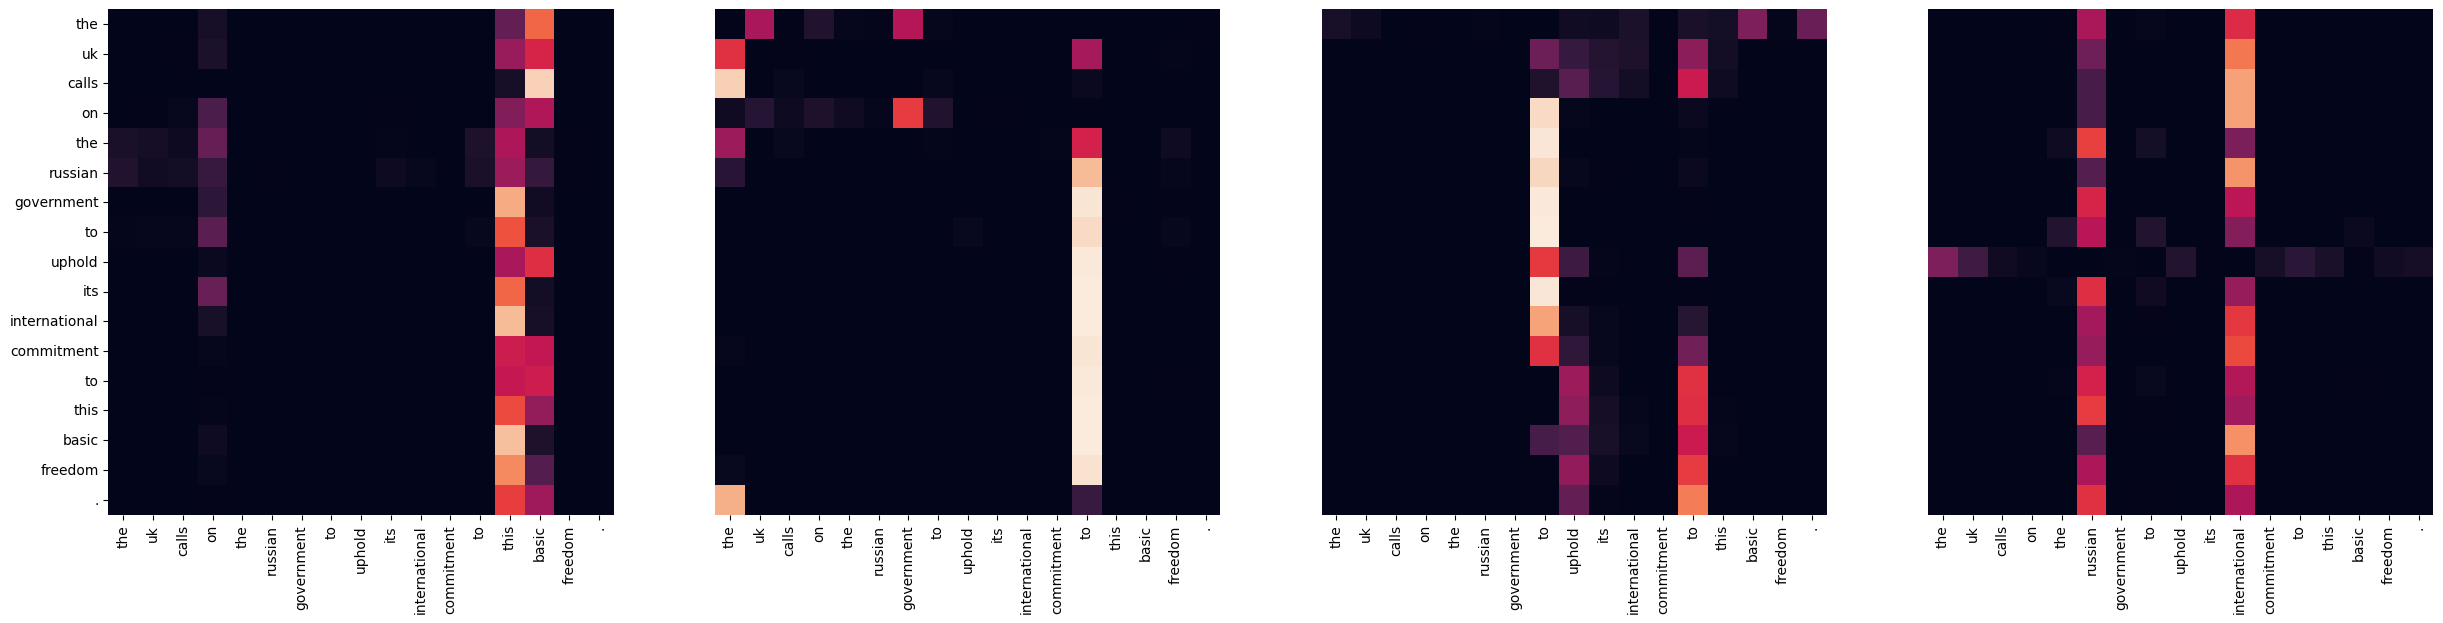

Encoder Layer 4


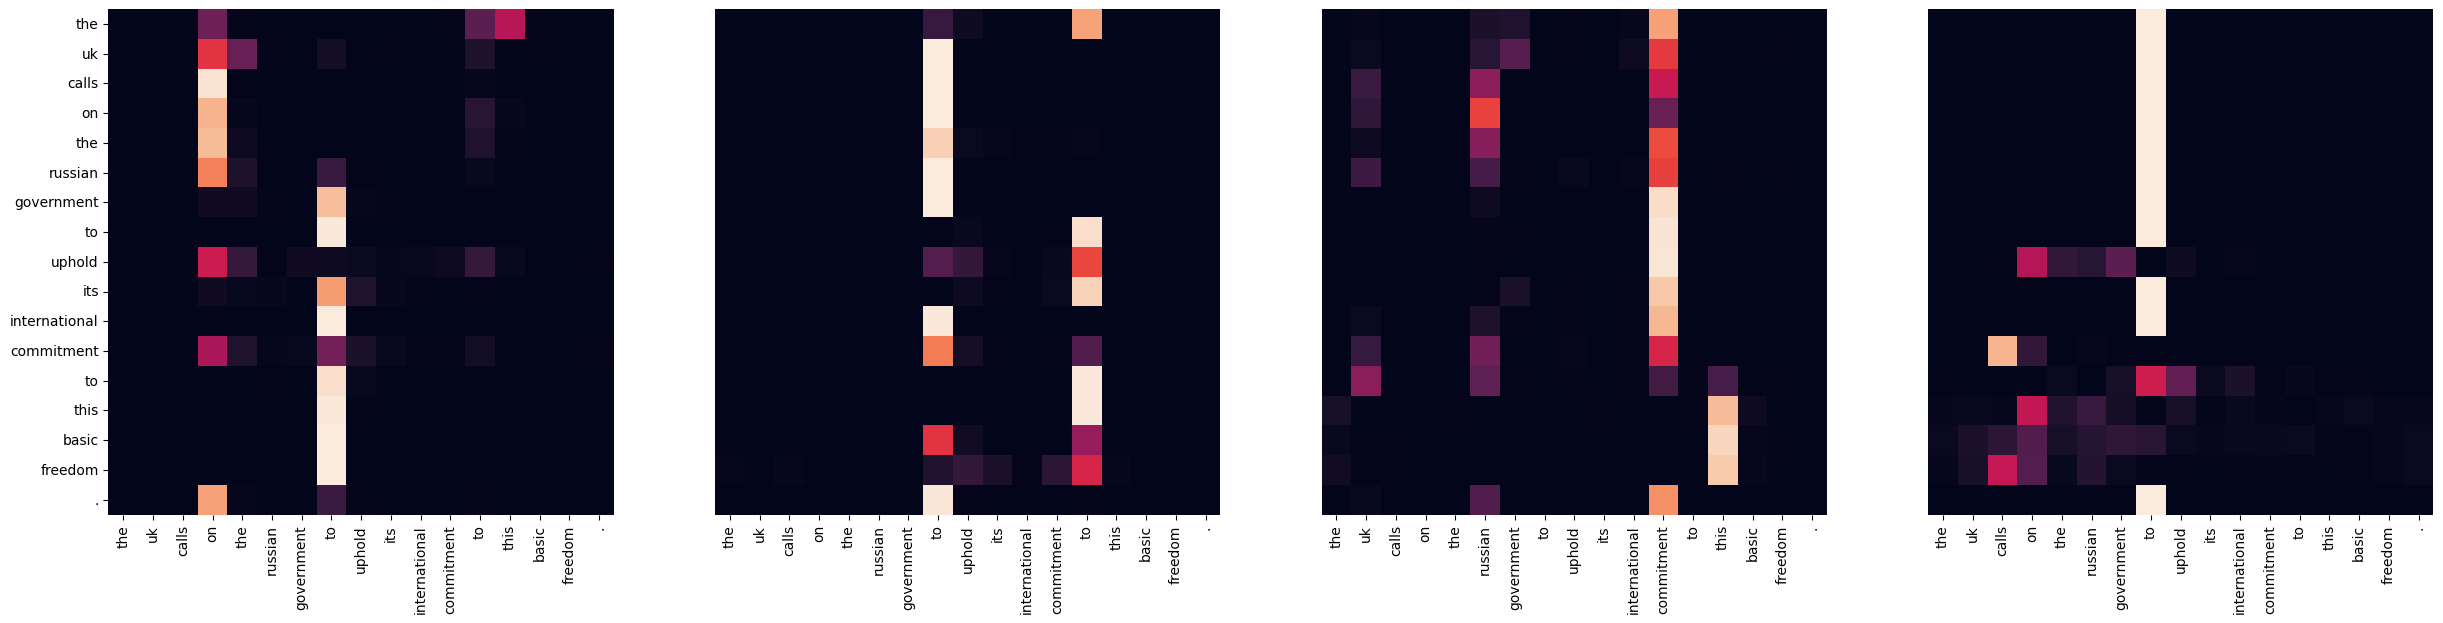

Encoder Layer 6


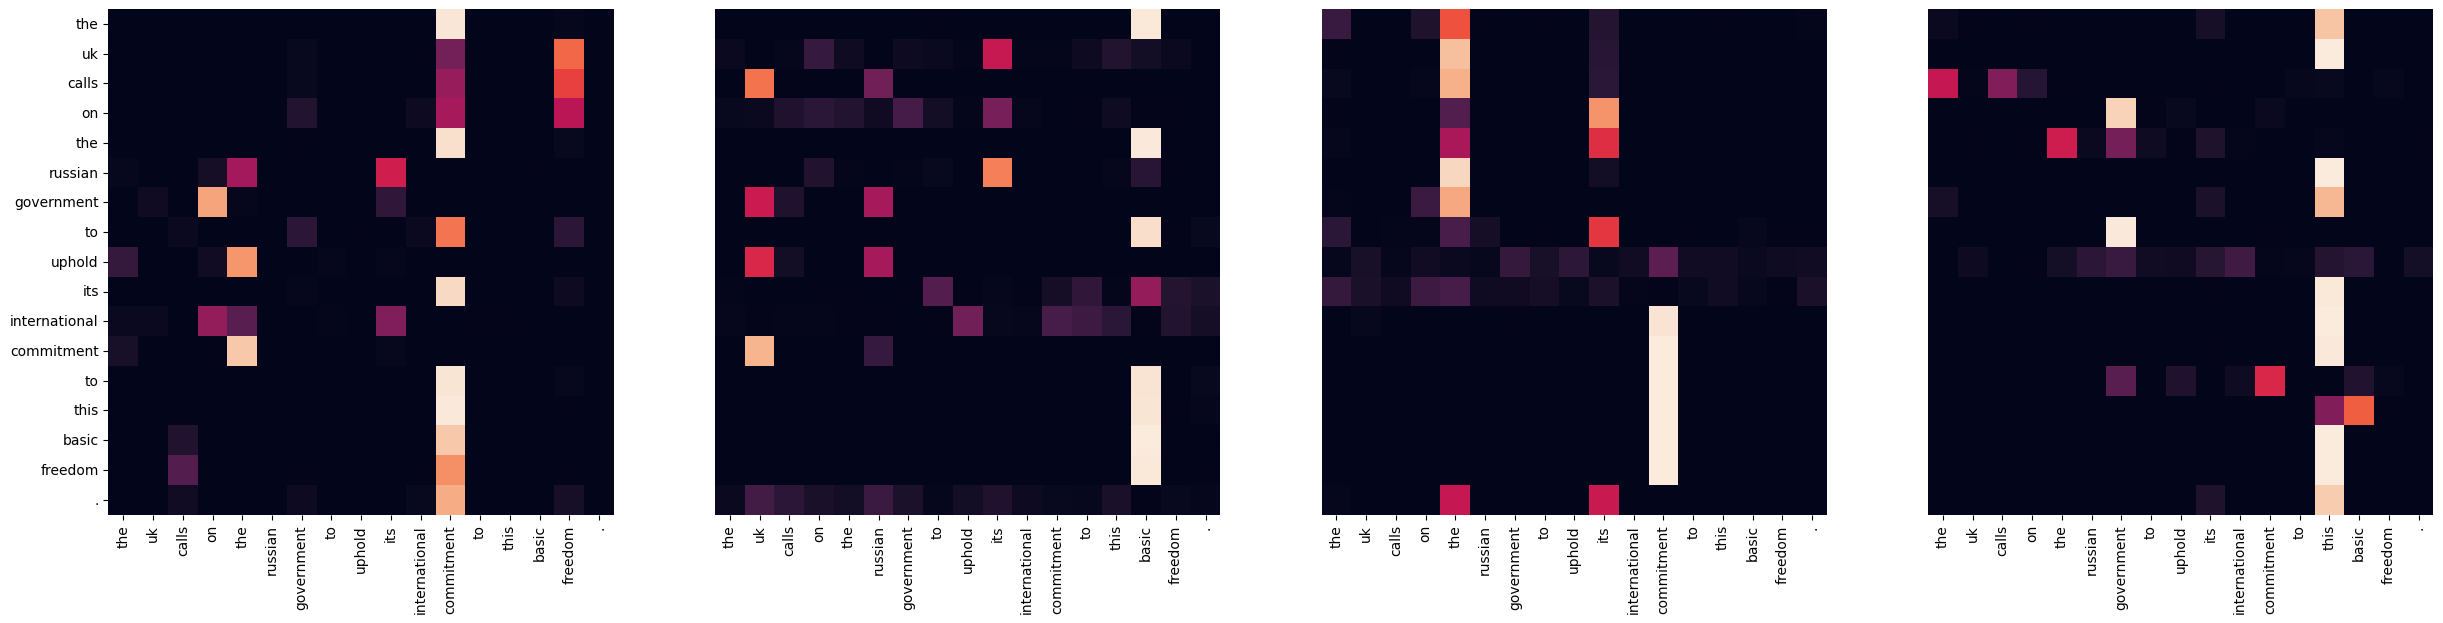

In [ ]:
sent = en_tokenizer.tokenize(src.lower())

for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(30, 15))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].attn.attn[0, h].data.cpu(),
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()

## Visualize Decoder

Decoder Self Layer 2


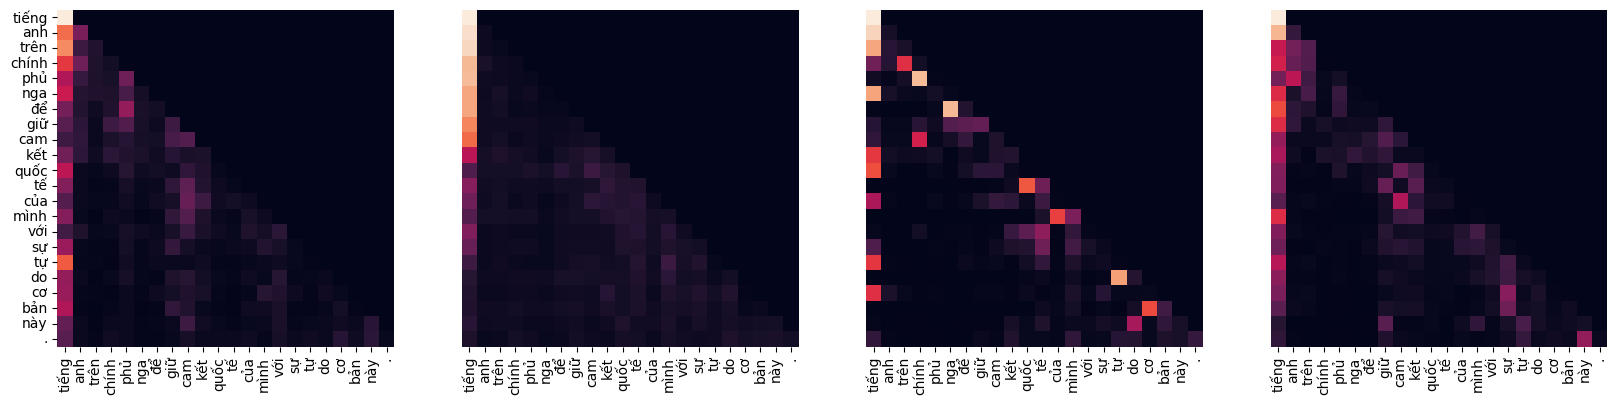

Decoder Src Layer 2


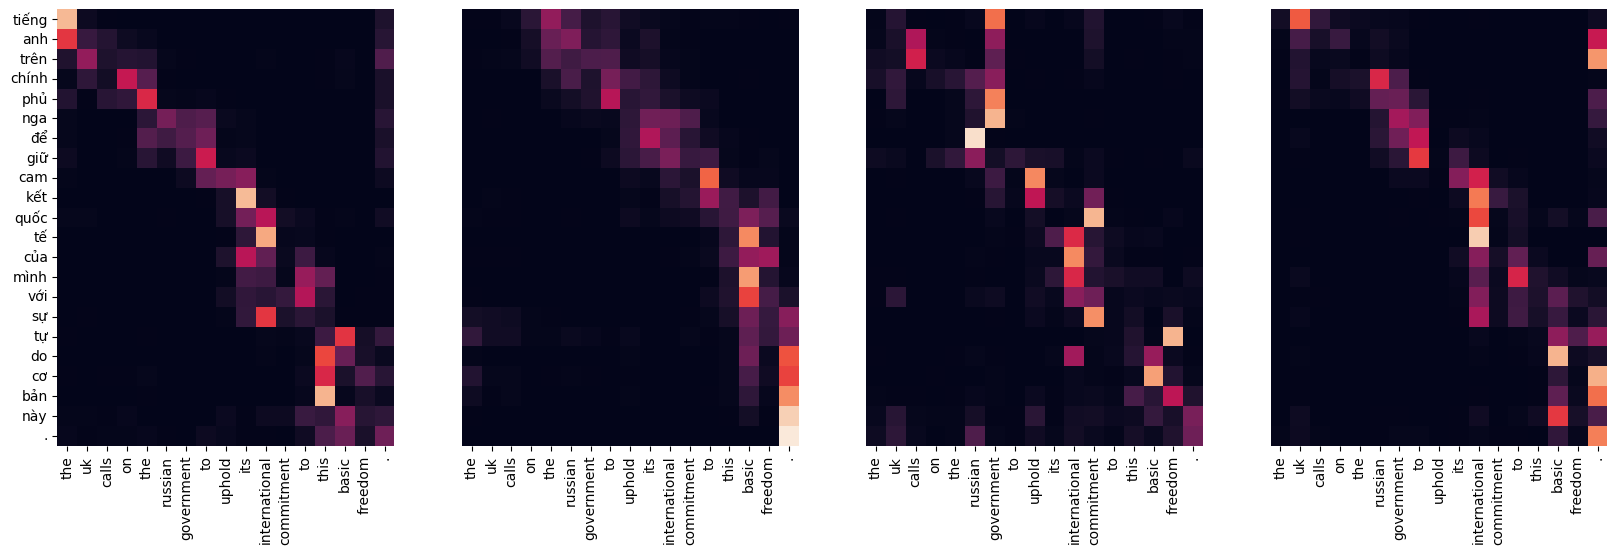

Decoder Self Layer 4


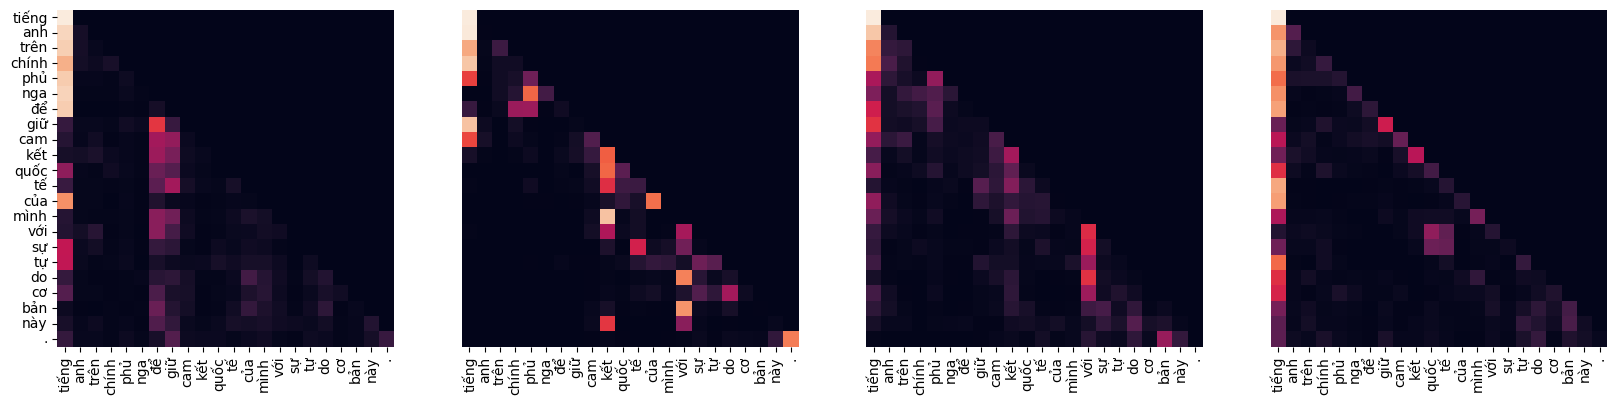

Decoder Src Layer 4


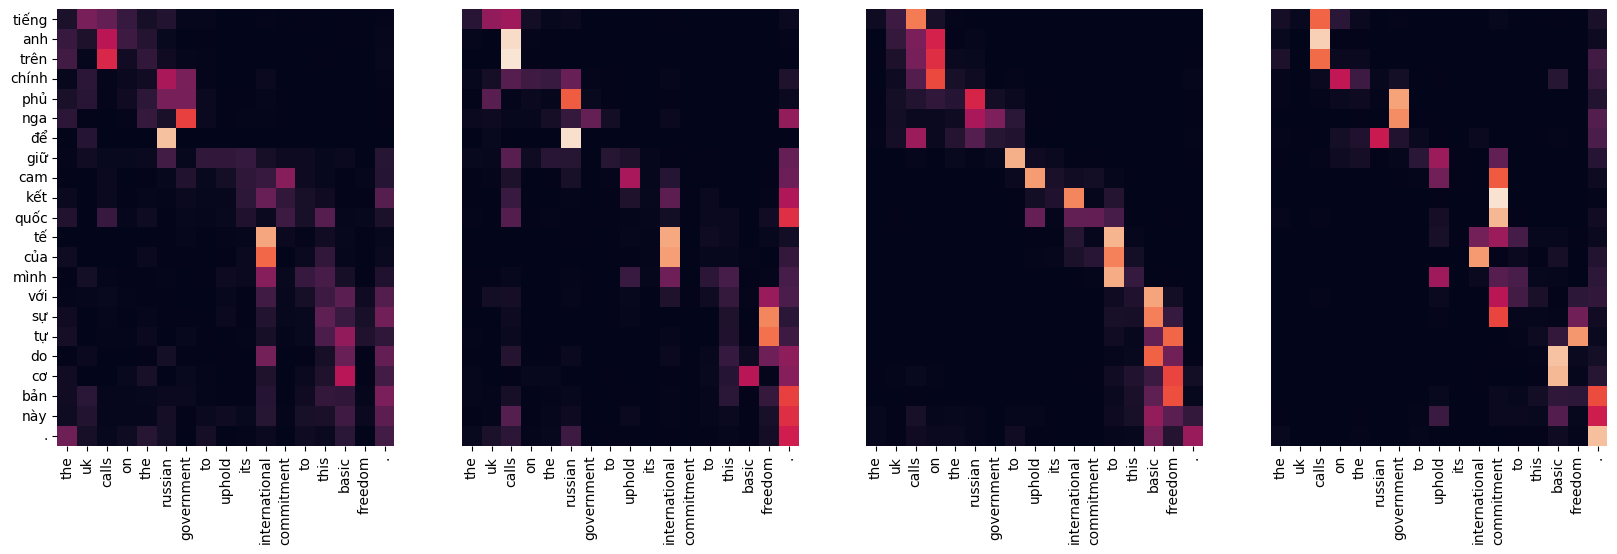

Decoder Self Layer 6


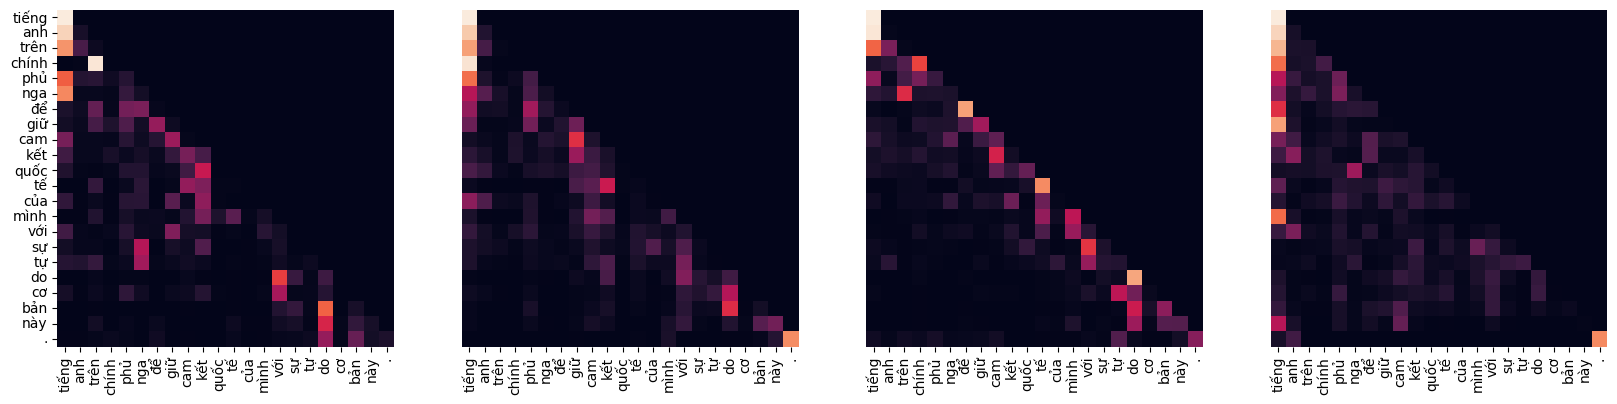

Decoder Src Layer 6


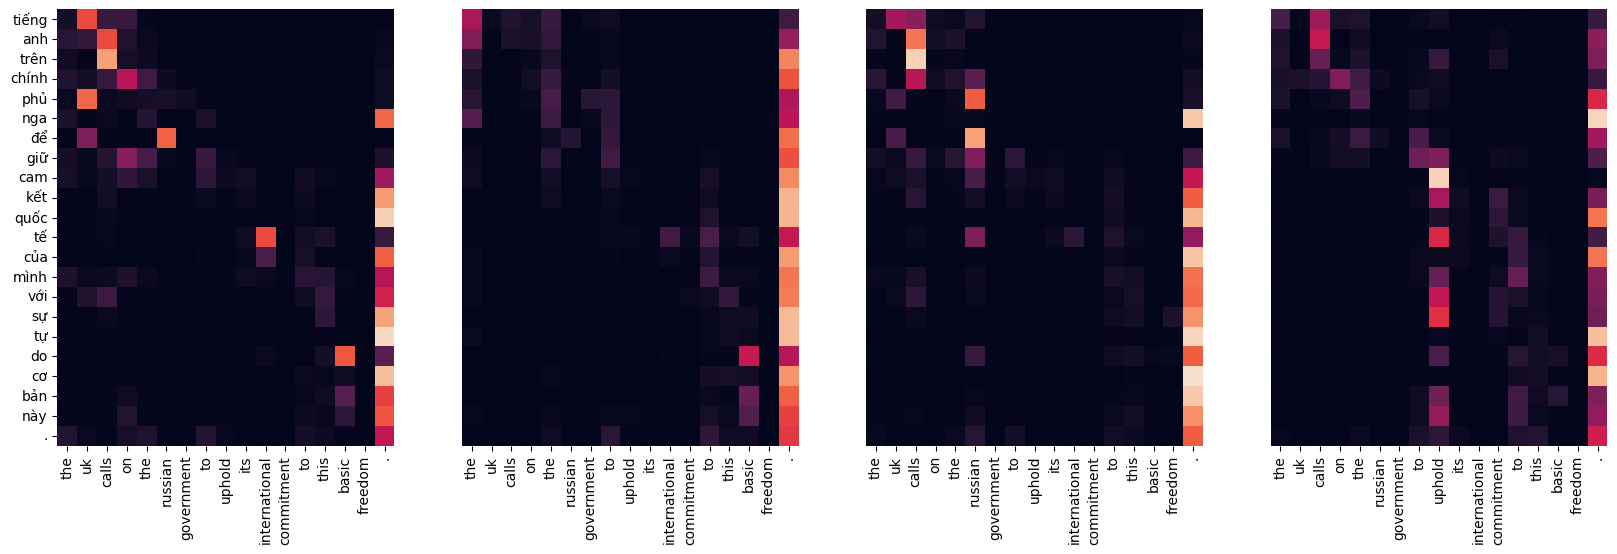

In [ ]:
trg_sent = vi_tokenizer.tokenize(pred.lower())

for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].attn_1.attn[0, h].data[:len(trg_sent), :len(trg_sent)].cpu(),
            trg_sent, trg_sent if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].attn_2.attn[0, h].data[:len(trg_sent), :len(sent)].cpu(),
            sent, trg_sent if h ==0 else [], ax=axs[h])
    plt.show()